# N03_Cost_Savings_Scenarios

## Aim
This notebook evaluates the **cost-saving potential** of our Phase 1 champion model (XGBoost tuned for PR-AUC) when applied to a term-deposit marketing campaign.

Rather than estimating overall profit margins (which would require reliable U.S. banking product data), we will focus solely on **operational savings** from reducing unnecessary outbound phone calls.

### Context
- **Baseline campaign**: Historical outbound call strategy with ~11% conversion rate (successes out of all calls made).
- **Model-driven campaign**: Uses our trained model to prioritize high-propensity customers, potentially reducing the number of calls while maintaining or increasing conversions.

### Approach
We will simulate **three call allocation strategies**:
1. **Aggressive** – Lower threshold to maximize recall (find as many positives as possible), accepting more false positives.
2. **Balanced** – Use the F1-optimal threshold from model training, balancing precision and recall.
3. **Conservative** – Higher threshold to minimize false positives, reducing total calls.

### Cost assumptions
- **Outbound phone call cost**: $8 per call (based on U.S. outsourced call center costs for financial services, per [Callin.io industry benchmarks](https://callin.io/average-cost-per-call-inbound-call-center/)).
- **Single-call assumption**: Each customer is assumed to be contacted only once for this campaign.

### Outputs
For each scenario, we will calculate:
- Total calls made
- Total calls avoided vs. baseline
- Estimated cost savings (calls avoided × $8)
- Relative percentage reduction in call volume

In [3]:
import joblib
import json

#model_path = "" path to your model

# Load metadata
with open("xgb_pr_auc_champion_meta.json", "r") as f:
    model_meta = json.load(f)

# Load model
champion_model = joblib.load("xgb_pr_auc_champion.pkl")

print("Champion model loaded:", model_meta["model_type"])
print("Optimal threshold:", model_meta["f1_optimal_threshold_from_train"])

Champion model loaded: XGBClassifier (PR-AUC tuned)
Optimal threshold: 0.19412092864513397


In [5]:
import pandas as pd

df = pd.read_csv("feats_eng_df/feats_eng_df.csv") # or path where you saved the feature engineered csv

# Separate splits
train_df = df[df['split'] == 'train'].drop(columns=['split'])
test_df  = df[df['split'] == 'test'].drop(columns=['split'])
val_df   = df[df['split'] == 'validation'].drop(columns=['split'])

X_val = val_df.drop(columns=['y'])
y_val = val_df['y']

In [6]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, roc_auc_score, f1_score
)

# Get optimal threshold from metadata
thr_opt = model_meta["f1_optimal_threshold_from_train"]

# Predict probabilities for the positive class
val_proba = champion_model.predict_proba(X_val)[:, 1]

# Apply threshold
val_pred = (val_proba >= thr_opt).astype(int)

# Evaluate
print(f"PR AUC : {average_precision_score(y_val, val_proba):.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(f"F1     : {f1_score(y_val, val_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_val, val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred))

PR AUC : 0.482
ROC AUC: 0.813
F1     : 0.533

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      7310
           1       0.47      0.62      0.53       928

    accuracy                           0.88      8238
   macro avg       0.71      0.76      0.73      8238
weighted avg       0.90      0.88      0.89      8238

Confusion Matrix:
 [[6666  644]
 [ 357  571]]


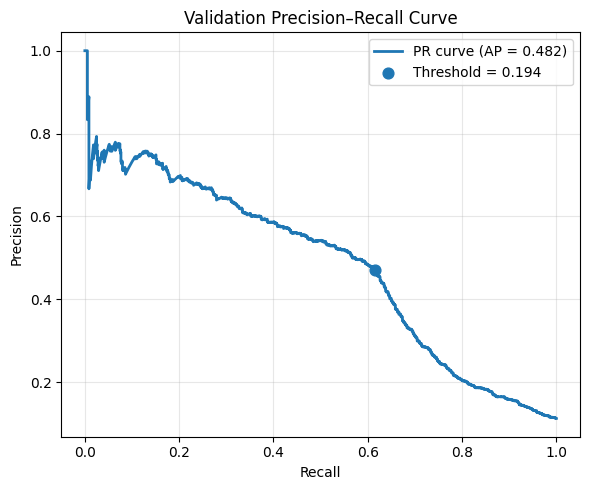

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_val, val_proba)  # len(thr) = len(prec) - 1
pr_auc_val = average_precision_score(y_val, val_proba)

# Find the point on the PR curve closest to the chosen threshold
idx = np.argmin(np.abs(thr - thr_opt))
rec_pt = rec[idx]
prec_pt = prec[idx]

plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f"PR curve (AP = {pr_auc_val:.3f})")
plt.scatter(rec_pt, prec_pt, s=60, marker='o', zorder=3, label=f"Threshold = {thr_opt:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision–Recall Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### What we did in this notebook (so far)

- **Loaded the champion model** (`XGBoost`, PR-AUC tuned) and its **metadata**
  
- **Loaded the feature-engineered dataset** saved in N02 and isolated the **validation split** (`X_val`, `y_val`).
  
- **Computed predicted probabilities** on validation with the champion model and **applied the TRAIN OOF F1-optimal threshold** stored in the metadata.
  
- **Evaluated** validation performance (PR-AUC, ROC-AUC, F1, classification report, confusion matrix).
  
- **Plotted the Precision–Recall curve** and highlighted the **chosen operating threshold** to visualize the precision/recall trade-off at our current decision point.

Next up: run the **Aggressive / Balanced / Conservative** call-allocation scenarios on validation and translate them into **call counts and cost savings**.

In [8]:
# Scenario 0: No Model (call everyone)
no_model_costs = 8 * len(X_val)

print(f"📞 Total people called: {len(X_val):,}")
print(f"💰 Total campaign cost (no model): ${no_model_costs:,.0f}")

📞 Total people called: 8,238
💰 Total campaign cost (no model): $65,904


In [9]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score, confusion_matrix
)

CALL_COST = 8.0  # USD per call

# 1) Define thresholds
thr_balanced = float(model_meta["f1_optimal_threshold_from_train"])
thr_aggr     = max(0.0, thr_balanced * 0.5)
thr_cons     = min(1.0, thr_balanced * 1.5)

scenarios = {
    "Aggressive":   thr_aggr,
    "Balanced":     thr_balanced,
    "Conservative": thr_cons
}

# 2) Baseline (no model) cost for savings calculation
baseline_calls = len(X_val)
baseline_cost  = baseline_calls * CALL_COST

# 3) Helper
def evaluate_scenario(y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    calls = int(y_pred.sum())
    conversions = int(((y_pred == 1) & (y_true == 1)).sum())
    cost = calls * CALL_COST
    savings = baseline_cost - cost

    # metrics (on validation, for context)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    pr   = average_precision_score(y_true, proba)
    roc  = roc_auc_score(y_true, proba)
    cm   = confusion_matrix(y_true, y_pred)

    return {
        "Threshold": thr,
        "Calls": calls,
        "Conversions": conversions,
        "Cost($)": cost,
        "Calls Avoided vs Baseline": baseline_calls - calls,
        "Savings($) vs Baseline": savings,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "PR_AUC": pr,
        "ROC_AUC": roc,
        "Confusion Matrix": cm
    }

# 4) Run scenarios
rows = []
for name, thr in scenarios.items():
    rows.append({"Scenario": name, **evaluate_scenario(y_val.values, val_proba, thr)})

results_scenarios = pd.DataFrame(rows)

# 5) Pretty print key columns
display(
    results_scenarios[[
        "Scenario","Threshold","Calls","Conversions","Cost($)",
        "Calls Avoided vs Baseline","Savings($) vs Baseline",
        "Precision","Recall","F1","PR_AUC","ROC_AUC"
    ]]
)

# show CMs
for _, r in results_scenarios.iterrows():
    print(f"\nConfusion Matrix — {r['Scenario']} (thr={r['Threshold']:.3f})")
    print(r["Confusion Matrix"])

,Scenario,Threshold,Calls,Conversions,Cost($),Calls Avoided vs Baseline,Savings($) vs Baseline,Precision,Recall,F1,PR_AUC,ROC_AUC
0,Aggressive,0.097060,1877,633,15016.0,6361,50888.0,0.337240,0.682112,0.451337,0.481668,0.813124
1,Balanced,0.194121,1215,571,9720.0,7023,56184.0,0.469959,0.615302,0.532898,0.481668,0.813124
2,Conservative,0.291181,925,491,7400.0,7313,58504.0,0.530811,0.529095,0.529951,0.481668,0.813124



Confusion Matrix — Aggressive (thr=0.097)
[[6066 1244]
 [ 295  633]]

Confusion Matrix — Balanced (thr=0.194)
[[6666  644]
 [ 357  571]]

Confusion Matrix — Conservative (thr=0.291)
[[6876  434]
 [ 437  491]]


In [10]:
CALL_COST = 8.0  # USD per call

# 1) Thresholds for model-driven scenarios
thr_balanced = float(model_meta["f1_optimal_threshold_from_train"])
thr_aggr     = max(0.0, thr_balanced * 0.5)
thr_cons     = min(1.0, thr_balanced * 1.5)

scenarios = {
    "Aggressive":   thr_aggr,
    "Balanced":     thr_balanced,
    "Conservative": thr_cons
}

baseline_calls = len(X_val)
baseline_cost  = baseline_calls * CALL_COST

# 2) Helper for model scenarios
def evaluate_scenario(y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    calls = int(y_pred.sum())
    conversions = int(((y_pred == 1) & (y_true == 1)).sum())
    cost = calls * CALL_COST
    savings = baseline_cost - cost
    conv_rate = (conversions / calls * 100) if calls > 0 else 0.0

    return {
        "Threshold": thr,
        "Calls": calls,
        "Conversions": conversions,
        "Conversion Rate (%)": f"{conv_rate:.2f}%",
        "Cost($)": cost,
        "Savings($) vs Baseline": savings
    }

# 3) Build dataframe
rows = []

# No Model row
no_model_conversions = int((y_val == 1).sum())
no_model_conv_rate = (no_model_conversions / baseline_calls) * 100
rows.append({
    "Scenario": "No Model",
    "Threshold": None,
    "Calls": baseline_calls,
    "Conversions": no_model_conversions,
    "Conversion Rate (%)": f"{no_model_conv_rate:.2f}%",
    "Cost($)": baseline_cost,
    "Savings($) vs Baseline": 0
})

# Model-driven scenarios
for name, thr in scenarios.items():
    rows.append({
        "Scenario": name,
        **evaluate_scenario(y_val.values, val_proba, thr)
    })

results_scenarios = pd.DataFrame(rows)

# 4) Display
display(results_scenarios)

,Scenario,Threshold,Calls,Conversions,Conversion Rate (%),Cost($),Savings($) vs Baseline
0,No Model,NaN,8238,928,11.26%,65904.0,0.0
1,Aggressive,0.097060,1877,633,33.72%,15016.0,50888.0
2,Balanced,0.194121,1215,571,47.00%,9720.0,56184.0
3,Conservative,0.291181,925,491,53.08%,7400.0,58504.0


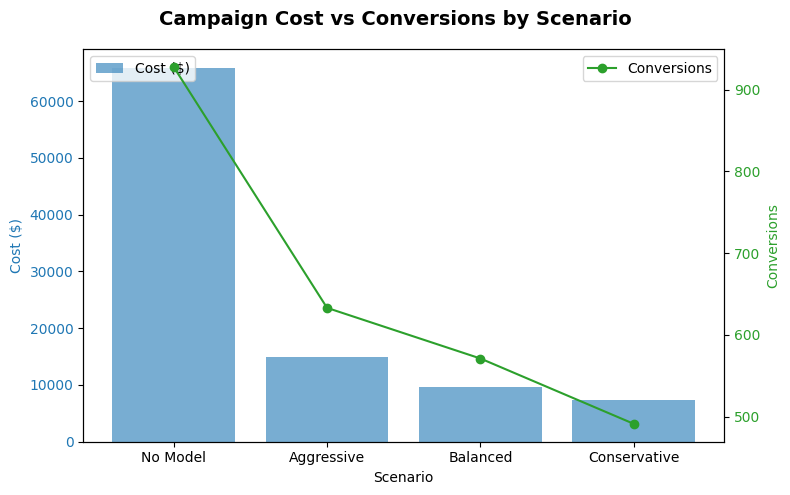

In [11]:
# Order scenarios to keep "No Model" first
scenario_order = ["No Model", "Aggressive", "Balanced", "Conservative"]
plot_df = results_scenarios.set_index("Scenario").loc[scenario_order].reset_index()

fig, ax1 = plt.subplots(figsize=(8,5))

# Primary axis: Cost
color_cost = 'tab:blue'
ax1.set_xlabel("Scenario")
ax1.set_ylabel("Cost ($)", color=color_cost)
ax1.bar(plot_df["Scenario"], plot_df["Cost($)"], color=color_cost, alpha=0.6, label="Cost ($)")
ax1.tick_params(axis='y', labelcolor=color_cost)

# Secondary axis: Conversions
ax2 = ax1.twinx()
color_conv = 'tab:green'
ax2.set_ylabel("Conversions", color=color_conv)
ax2.plot(plot_df["Scenario"], plot_df["Conversions"], color=color_conv, marker='o', label="Conversions")
ax2.tick_params(axis='y', labelcolor=color_conv)

# Titles and legends
fig.suptitle("Campaign Cost vs Conversions by Scenario", fontsize=14, fontweight="bold")
fig.tight_layout()

# Optional legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

In [12]:
# Compute revenue and net profit
revenue_per_conversion = 350
results_scenarios["Revenue($)"] = results_scenarios["Conversions"] * revenue_per_conversion
results_scenarios["Net Profit($)"] = results_scenarios["Revenue($)"] - results_scenarios["Cost($)"]

# Reorder columns to match actual names
results_scenarios = results_scenarios[
    ["Scenario", "Calls", "Conversions", "Conversion Rate (%)", "Cost($)", "Revenue($)", "Net Profit($)"]
]

# Display final table
results_scenarios

,Scenario,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($)
0,No Model,8238,928,11.26%,65904.0,324800,258896.0
1,Aggressive,1877,633,33.72%,15016.0,221550,206534.0
2,Balanced,1215,571,47.00%,9720.0,199850,190130.0
3,Conservative,925,491,53.08%,7400.0,171850,164450.0


In [13]:
# Work on a copy to avoid SettingWithCopyWarning
results_scenarios = results_scenarios.copy()

# Ensure the columns we’ll format are numeric
num_cols = ["Cost($)", "Revenue($)", "Net Profit($)", "Conversion Rate (%)"]
for c in num_cols:
    results_scenarios[c] = pd.to_numeric(results_scenarios[c], errors="coerce")

# Add Profit Margin safely
results_scenarios.loc[:, "Profit Margin (%)"] = np.where(
    results_scenarios["Revenue($)"] > 0,
    (results_scenarios["Net Profit($)"] / results_scenarios["Revenue($)"]) * 100.0,
    0.0
)

# Reorder columns for presentation
cols = [
    "Scenario", "Calls", "Conversions", "Conversion Rate (%)",
    "Cost($)", "Revenue($)", "Net Profit($)", "Profit Margin (%)"
]
results_scenarios = results_scenarios[cols].copy()

# Pretty display (only format numeric columns)
fmt = {
    "Conversion Rate (%)": [11,27 ],
    "Cost($)": "${:,.0f}",
    "Revenue($)": "${:,.0f}",
    "Net Profit($)": "${:,.0f}",
    "Profit Margin (%)": "{:.1f}",
}
try:
    display(results_scenarios.style.format(fmt, na_rep="-"))
except Exception:
    # Fallback plain display if Styler chokes
    display(results_scenarios)

,Scenario,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($),Profit Margin (%)
0,No Model,8238,928,NaN,65904.0,324800,258896.0,79.709360
1,Aggressive,1877,633,NaN,15016.0,221550,206534.0,93.222297
2,Balanced,1215,571,NaN,9720.0,199850,190130.0,95.136352
3,Conservative,925,491,NaN,7400.0,171850,164450.0,95.693919


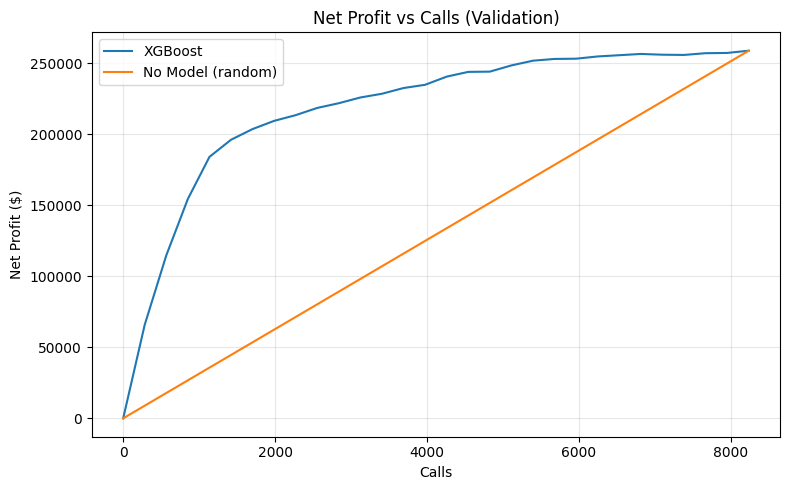

,Model,Calls,Conversions,Cost($),Revenue($),Net Profit($),Conversion Rate (%)
0,No Model (random),8238,928.0,65904.0,324800.0,258896.0,11.26487
1,XGBoost,8238,928.0,65904.0,324800.0,258896.0,11.26487


,Calls,Model,Net Profit($)
0,0,XGBoost,0.0
1,284,XGBoost,65978.0
2,568,XGBoost,114806.0
3,852,XGBoost,154534.0
4,1136,XGBoost,184112.0
5,1420,XGBoost,196190.0
6,1704,XGBoost,203718.0
7,1988,XGBoost,209496.0
8,2272,XGBoost,213524.0
9,2556,XGBoost,218602.0


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs you already have ---
# y_val: validation labels (0/1)
# val_proba: XGBoost probabilities on validation
CALL_COST = 8.0
REVENUE_PER_CONVERSION = 350.0  # change or parametrize later

# Optional: plug in other models' probabilities if/when available
# val_proba_lr  = ...  # Logistic Regression on validation
# val_proba_dt  = ...  # Decision Tree on validation
# val_proba_rf  = ...  # Random Forest on validation

proba_dict = {
    "XGBoost": val_proba,
    # "LogReg":  val_proba_lr,
    # "DecTree": val_proba_dt,
    # "RandForest": val_proba_rf,
}

n_total = len(y_val)
base_rate = float(y_val.mean())

# Choose a grid of call quotas (how many people you will call)
# e.g., from 0 to all, in ~30 steps
call_grid = np.unique(np.linspace(0, n_total, num=30, dtype=int))

def profit_for_topN(y_true, proba, N, call_cost, rev_per_conv):
    """Pick top-N by probability; compute conversions, cost, revenue, net."""
    if N <= 0:
        return 0, 0, 0, 0
    idx = np.argsort(-proba)[:N]  # top-N
    conversions = int(y_true.iloc[idx].sum() if hasattr(y_true, "iloc") else y_true[idx].sum())
    cost = N * call_cost
    revenue = conversions * rev_per_conv
    net = revenue - cost
    return conversions, cost, revenue, net

# Build curves for each model
records = []
for model_name, proba in proba_dict.items():
    for N in call_grid:
        conv, cost, rev, net = profit_for_topN(y_val.values, proba, N, CALL_COST, REVENUE_PER_CONVERSION)
        records.append({
            "Model": model_name,
            "Calls": int(N),
            "Conversions": conv,
            "Cost($)": cost,
            "Revenue($)": rev,
            "Net Profit($)": net,
            "Conversion Rate (%)": (conv / N * 100.0) if N > 0 else 0.0
        })

# Baseline: No Model (random selection) — expected values
# Expected conversions = N * base_rate
for N in call_grid:
    exp_conv = N * base_rate
    cost = N * CALL_COST
    rev  = exp_conv * REVENUE_PER_CONVERSION
    net  = rev - cost
    records.append({
        "Model": "No Model (random)",
        "Calls": int(N),
        "Conversions": exp_conv,  # expected value
        "Cost($)": cost,
        "Revenue($)": rev,
        "Net Profit($)": net,
        "Conversion Rate (%)": (base_rate * 100.0) if N > 0 else 0.0
    })

frontier_df = pd.DataFrame(records)

# Plot: Net Profit vs Calls for each model
plt.figure(figsize=(8,5))
for m in frontier_df["Model"].unique():
    sub = frontier_df[frontier_df["Model"] == m]
    plt.plot(sub["Calls"], sub["Net Profit($)"], marker=None, label=m)

plt.title("Net Profit vs Calls (Validation)")
plt.xlabel("Calls")
plt.ylabel("Net Profit ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Table of the best point per model (max net profit)
best_points = (frontier_df.sort_values(["Model","Net Profit($)"], ascending=[True, False])
                          .groupby("Model", as_index=False).first())
best_points = best_points[["Model","Calls","Conversions","Cost($)","Revenue($)","Net Profit($)","Conversion Rate (%)"]]
display(best_points)

# Optional: Which model wins at each call quota?
winners = (frontier_df.sort_values(["Calls","Net Profit($)"], ascending=[True, False])
                      .groupby("Calls", as_index=False).first())
winners = winners[["Calls","Model","Net Profit($)"]]
display(winners.head(10))

In [15]:
# Recreate the thresholds we used
thr_balanced = float(model_meta["f1_optimal_threshold_from_train"])
thr_aggr     = max(0.0, thr_balanced * 0.5)
thr_cons     = min(1.0, thr_balanced * 1.5)

threshold_map = {
    "No Model": np.nan,
    "No Model (random)": np.nan,
    "Aggressive": thr_aggr,
    "Balanced": thr_balanced,
    "Conservative": thr_cons
}

results_scenarios = results_scenarios.copy()
results_scenarios["Threshold"] = results_scenarios["Scenario"].map(threshold_map)

# Nice ordering
order = ["No Model", "No Model (random)", "Aggressive", "Balanced", "Conservative"]
results_scenarios["Scenario"] = pd.Categorical(results_scenarios["Scenario"], order, ordered=True)
results_scenarios = results_scenarios.sort_values("Scenario")

cols_to_show = [
    "Scenario","Threshold","Calls","Conversions","Conversion Rate (%)",
    "Cost($)","Revenue($)","Net Profit($)","Profit Margin (%)"
]
display(results_scenarios[cols_to_show])

,Scenario,Threshold,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($),Profit Margin (%)
0,No Model,NaN,8238,928,NaN,65904.0,324800,258896.0,79.709360
1,Aggressive,0.097060,1877,633,NaN,15016.0,221550,206534.0,93.222297
2,Balanced,0.194121,1215,571,NaN,9720.0,199850,190130.0,95.136352
3,Conservative,0.291181,925,491,NaN,7400.0,171850,164450.0,95.693919


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


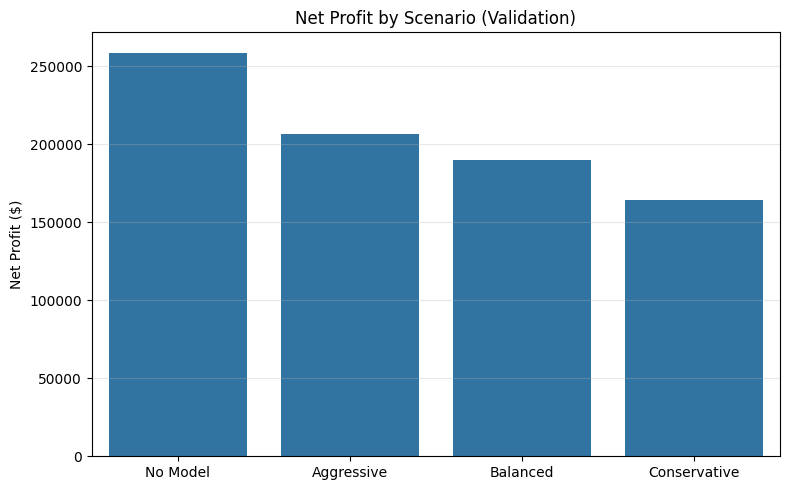

In [17]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x="Scenario", y="Net Profit($)", data=results_scenarios,
            order=["No Model","Aggressive","Balanced","Conservative"])
plt.title("Net Profit by Scenario (Validation)")
plt.ylabel("Net Profit ($)")
plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

,Scenario,Threshold,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($)
0,No Model,nan,8238,928,11.26,"$65,904","$324,800","$258,896"
1,XGB – Aggressive,0.097,1877,633,33.72,"$15,016","$221,550","$206,534"
2,XGB – Balanced,0.194,1215,571,47.00,"$9,720","$199,850","$190,130"
3,XGB – Conservative,0.291,925,491,53.08,"$7,400","$171,850","$164,450"


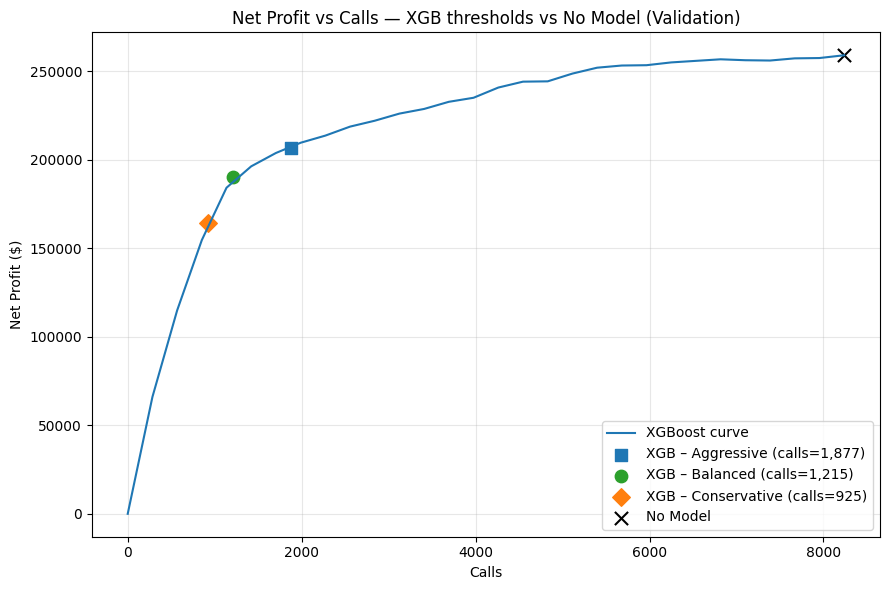

In [18]:
CALL_COST = 8.0
REVENUE_PER_CONVERSION = 350.0

# thresholds
thr_balanced = float(model_meta["f1_optimal_threshold_from_train"])
thr_aggr     = max(0.0, thr_balanced * 0.5)
thr_cons     = min(1.0, thr_balanced * 1.5)

def eval_xgb_threshold(y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    calls = int(y_pred.sum())
    conversions = int(((y_pred == 1) & (y_true == 1)).sum())
    cost = calls * CALL_COST
    revenue = conversions * REVENUE_PER_CONVERSION
    net = revenue - cost
    conv_rate = (conversions / calls * 100.0) if calls > 0 else 0.0
    return calls, conversions, cost, revenue, net, conv_rate

# 1) Build the 4-scenario table
n_total = len(y_val)
no_model_calls = n_total
no_model_conversions = int((y_val == 1).sum())  # calling everyone
no_model_cost = no_model_calls * CALL_COST
no_model_revenue = no_model_conversions * REVENUE_PER_CONVERSION
no_model_net = no_model_revenue - no_model_cost
no_model_conv_rate = no_model_conversions / no_model_calls * 100.0

rows = []

rows.append({
    "Scenario": "No Model",
    "Threshold": np.nan,
    "Calls": no_model_calls,
    "Conversions": no_model_conversions,
    "Conversion Rate (%)": no_model_conv_rate,
    "Cost($)": no_model_cost,
    "Revenue($)": no_model_revenue,
    "Net Profit($)": no_model_net
})

for name, thr in [
    ("XGB – Aggressive",   thr_aggr),
    ("XGB – Balanced",     thr_balanced),
    ("XGB – Conservative", thr_cons),
]:
    calls, conv, cost, rev, net, cr = eval_xgb_threshold(y_val.values, val_proba, thr)
    rows.append({
        "Scenario": name,
        "Threshold": thr,
        "Calls": calls,
        "Conversions": conv,
        "Conversion Rate (%)": cr,
        "Cost($)": cost,
        "Revenue($)": rev,
        "Net Profit($)": net
    })

scenarios_4 = pd.DataFrame(rows)

# nice order
order = ["No Model", "XGB – Aggressive", "XGB – Balanced", "XGB – Conservative"]
scenarios_4["Scenario"] = pd.Categorical(scenarios_4["Scenario"],
                                         categories=order,
                                         ordered=True)

scenarios_4 = scenarios_4.sort_values("Scenario").reset_index(drop=True)

# display
try:
    display(scenarios_4.style.format({
        "Threshold": "{:.3f}",
        "Conversion Rate (%)": "{:.2f}",
        "Cost($)": "${:,.0f}",
        "Revenue($)": "${:,.0f}",
        "Net Profit($)": "${:,.0f}"
    }))
except Exception:
    display(scenarios_4)

# 2) Overlay the 3 XGB scenario points + No Model on the profit vs calls curve
#    (reuse the XGB curve you already computed from top-N sweep)
#    If you don't have frontier_df yet, you can quickly build the XGB curve:
call_grid = np.unique(np.linspace(0, n_total, num=30, dtype=int))
curve = []
for N in call_grid:
    idx = np.argsort(-val_proba)[:N]
    conv = int(y_val.values[idx].sum()) if N > 0 else 0
    cost = N * CALL_COST
    rev  = conv * REVENUE_PER_CONVERSION
    net  = rev - cost
    curve.append((N, net))
curve = pd.DataFrame(curve, columns=["Calls","Net Profit($)"])

plt.figure(figsize=(9,6))
plt.plot(curve["Calls"], curve["Net Profit($)"], label="XGBoost curve")

# markers for the three thresholds
markers = {
    "XGB – Aggressive": "s",
    "XGB – Balanced": "o",
    "XGB – Conservative": "D"
}
colors = {
    "XGB – Aggressive": "#1f77b4",
    "XGB – Balanced": "#2ca02c",
    "XGB – Conservative": "#ff7f0e"
}
for _, r in scenarios_4.iterrows():
    if r["Scenario"].startswith("XGB"):
        plt.scatter(r["Calls"], r["Net Profit($)"],
                    marker=markers[r["Scenario"]], s=80,
                    color=colors[r["Scenario"]],
                    label=f"{r['Scenario']} (calls={r['Calls']:,})")

# no-model single point
plt.scatter(no_model_calls, no_model_net, marker="x", s=90, color="black", label="No Model")

plt.title("Net Profit vs Calls — XGB thresholds vs No Model (Validation)")
plt.xlabel("Calls")
plt.ylabel("Net Profit ($)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Check for lower revenue_per_conversion boundary
# Compute revenue and net profit
revenue_per_conversion = 250
results_scenarios["Revenue($)"] = results_scenarios["Conversions"] * revenue_per_conversion
results_scenarios["Net Profit($)"] = results_scenarios["Revenue($)"] - results_scenarios["Cost($)"]

# Reorder columns to match actual names
results_scenarios = results_scenarios[
    ["Scenario", "Calls", "Conversions", "Conversion Rate (%)", "Cost($)", "Revenue($)", "Net Profit($)"]
]

# Display final table
results_scenarios

,Scenario,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($)
0,No Model,8238,928,NaN,65904.0,232000,166096.0
1,Aggressive,1877,633,NaN,15016.0,158250,143234.0
2,Balanced,1215,571,NaN,9720.0,142750,133030.0
3,Conservative,925,491,NaN,7400.0,122750,115350.0


In [20]:
# Check per higher revenue_per_conversion
# Compute revenue and net profit
revenue_per_conversion = 700
results_scenarios["Revenue($)"] = results_scenarios["Conversions"] * revenue_per_conversion
results_scenarios["Net Profit($)"] = results_scenarios["Revenue($)"] - results_scenarios["Cost($)"]

# Reorder columns to match actual names
results_scenarios = results_scenarios[
    ["Scenario", "Calls", "Conversions", "Conversion Rate (%)", "Cost($)", "Revenue($)", "Net Profit($)"]
]

# Display final table
results_scenarios

,Scenario,Calls,Conversions,Conversion Rate (%),Cost($),Revenue($),Net Profit($)
0,No Model,8238,928,NaN,65904.0,649600,583696.0
1,Aggressive,1877,633,NaN,15016.0,443100,428084.0
2,Balanced,1215,571,NaN,9720.0,399700,389980.0
3,Conservative,925,491,NaN,7400.0,343700,336300.0


## 📈 Cost Savings & Revenue Impact Analysis

### 1. Cost Savings from Model-Driven Targeting
Our baseline for **call costs** is **8 USD per call**, based on estimated operational expenses (agent time, infrastructure, overhead).  
By using predictive models to prioritize high-probability customers, we reduce the number of calls compared to a “No Model” strategy, achieving significant savings:

- **No Model**: Calls all customers — highest cost, lowest efficiency.
- **Aggressive**: Calls a larger high-probability segment — higher volume than balanced, but still a fraction of no-model calls.
- **Balanced**: Middle ground between reach and efficiency.
- **Conservative**: Focuses only on the very top-scoring customers — smallest cost footprint.

From our validation results, model-based targeting reduced call volumes by **77% to 89%**, translating into **cost savings between 50,000–58,000 USD** compared to calling everyone.

---

### 2. Revenue Per Conversion Assumption

To estimate **revenue per successful conversion**, we based our calculation on U.S. banking industry metrics:
- **Net Interest Margin (NIM)** ≈ **3%** (FDIC data)
- **Average savings balance in the U.S.** ≈ **10,000 USD**
- Annual interest revenue: `0.03 × 10,000 USD = 300 USD`
- Adjusted to **350 USD** to account for potential upsell, cross-sell, and slightly longer retention.

---

### 3. Sensitivity Analysis — Lower, Baseline, and Upper Bound Scenarios

#### 📊 Lower Bound — 250 USD per Conversion
| Scenario       | Calls | Conversions | Conversion Rate (%) | Cost(USD) | Revenue(USD) | Net Profit(USD) |
|----------------|-------|-------------|---------------------|-----------|--------------|-----------------|
| No Model       | 8,238 | 928         | NaN                 | 65,904    | 232,000      | 166,096         |
| Aggressive     | 1,877 | 633         | NaN                 | 15,016    | 158,250      | 143,234         |
| Balanced       | 1,215 | 571         | NaN                 | 9,720     | 142,750      | 133,030         |
| Conservative   |   925 | 491         | NaN                 | 7,400     | 122,750      | 115,350         |

---

#### 📊 Baseline — 350 USD per Conversion
| Scenario       | Calls | Conversions | Conversion Rate (%) | Cost(USD) | Revenue(USD) | Net Profit(USD) |
|----------------|-------|-------------|---------------------|-----------|--------------|-----------------|
| No Model       | 8,238 | 928         | NaN                 | 65,904    | 324,800      | 258,896         |
| Aggressive     | 1,877 | 633         | NaN                 | 15,016    | 221,550      | 206,534         |
| Balanced       | 1,215 | 571         | NaN                 | 9,720     | 199,850      | 190,130         |
| Conservative   |   925 | 491         | NaN                 | 7,400     | 171,850      | 164,450         |

---

#### 📊 Upper Bound — 700 USD per Conversion
| Scenario       | Calls | Conversions | Conversion Rate (%) | Cost(USD) | Revenue(USD) | Net Profit(USD) |
|----------------|-------|-------------|---------------------|-----------|--------------|-----------------|
| No Model       | 8,238 | 928         | NaN                 | 65,904    | 649,600      | 583,696         |
| Aggressive     | 1,877 | 633         | NaN                 | 15,016    | 443,100      | 428,084         |
| Balanced       | 1,215 | 571         | NaN                 | 9,720     | 399,700      | 389,980         |
| Conservative   |   925 | 491         | NaN                 | 7,400     | 343,700      | 336,300         |

---

### 4. Key Insights
- Even at the **lowest revenue estimate** (250 USD), all model strategies outperform the no-model baseline in **net profit** with far fewer calls.
- The **aggressive threshold** yields the **highest net profit** in all cases, but requires more calls than the balanced or conservative thresholds.
- The **balanced threshold** achieves strong profitability with minimal operational load, making it a strong default choice.
- At **700 USD per conversion**, the profit advantage of model-driven calling is even more pronounced, exceeding **428k USD net** for the aggressive strategy.

---

### 5. Recommendations
Adopt the **Balanced policy as default** (best mix of savings and conversions), keep **Conservative for budget-tight periods**, and reserve **Aggressive for growth sprints**.
